<a href="https://colab.research.google.com/github/Asif-Mammadov/mask-detection/blob/main/Mask_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab.patches import cv2_imshow
from PIL import Image
from shutil import copy2
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import torch
import torch.nn as nn

In [2]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Copy the data to a local collab instance
from zipfile import ZipFile
CWD = os.getcwd()
if not os.path.exists(os.path.join(CWD, 'dataset')):
  copy2('drive/MyDrive/datasets/RMFD/RMFD.zip', 'RMFD.zip')
  ZipFile('RMFD.zip', ).extractall()
  os.rename(os.path.join(CWD, 'self-built-masked-face-recognition-dataset'), os.path.join(CWD, 'dataset'))
  os.rename(os.path.join(CWD, 'dataset', 'AFDB_face_dataset'), os.path.join(CWD, 'dataset', 'without-mask'))
  os.rename(os.path.join(CWD, 'dataset', 'AFDB_masked_face_dataset'), os.path.join(CWD, 'dataset', 'with-mask'))
  os.remove('RMFD.zip')

In [4]:
!du -shc dataset/*

32K	dataset/Readme.docx
39M	dataset/with-mask
723M	dataset/without-mask
762M	total


In [5]:
!echo "With mask: " $(find dataset/with-mask -type f | wc -l)
!echo "Without mask: " $(find dataset/without-mask -type f | wc -l)

With mask:  2203
Without mask:  90468


In [6]:
def collect_images(label, category_path, image_list, label_list, n):
  c = 0
  for sub_name in os.listdir(category_path):
    sub_path = os.path.join(category_path, sub_name)
    for img_name in os.listdir(sub_path):
      img_path = os.path.join(sub_path, img_name)
      image_list.append(img_path)
      label_list.append(label)
      c += 1
      # Set a counter limit
      if c >= n:
        return

class MaskDataset(Dataset):
  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.transform = transforms.Compose([
                                         transforms.Resize((100, 100)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])
    self.image_list = []
    self.label_list = []
    self.categories = ["with-mask", "without-mask"]
    self.WIDTH, self.HEIGHT = 100, 100
    c_with_mask = c_without_mask = 0
    for category in self.categories:
      label = int(category == "with-mask")
      collect_images(label, os.path.join(root_dir, category), self.image_list, self.label_list, 2203)

  def __len__(self):
    return len(self.image_list)

  def __getitem__(self, idx):
    img = self.image_list[idx]
    img = Image.open(img).convert("RGB") # PIL
    img = self.transform(img)
    label = self.label_list[idx]
    return img, label

In [7]:
dataset = MaskDataset("dataset")
print(len(dataset))

4406


In [8]:
b, k = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
def show_image(image, title=None):
  for i in range(3):
    image[i] = image[i]*k[i] + b[i]
  new_image = image.permute(1, 2, 0)
  plt.imshow(new_image)

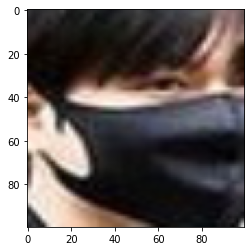

In [9]:
image, label = dataset[200]
show_image(image)

In [10]:

val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size
print(train_size, val_size)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(10))
print(len(train_dataset), len(val_dataset))

3525 881
3525 881


In [11]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, BATCH_SIZE, drop_last=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, drop_last=True)

In [12]:
for images, labels in train_loader:
  print(images.shape, labels.shape)
  break

torch.Size([32, 3, 100, 100]) torch.Size([32])


In [13]:
class CNNArchitecture(nn.Module):
  def __init__(self):
    super(CNNArchitecture, self).__init__()
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

    self.conv1 = nn.Conv2d(3, 32, (3, 3)) 
    self.max1 = nn.MaxPool2d(2, 2)

    self.conv2 = nn.Conv2d(32, 64, (3, 3))
    self.max2 = nn.MaxPool2d(2, 2)

    self.conv3 = nn.Conv2d(64, 128, (3, 3))
    self.max3 = nn.MaxPool2d(2,2)

    self.conv4 = nn.Conv2d(128, 256, (3, 3))
    self.max4 = nn.MaxPool2d(2, 2)

    self.conv5 = nn.Conv2d(256, 512, (3, 3))
    self.max5 = nn.MaxPool2d(2, 2)

    self.linear = nn.Linear(512, 2)

  def forward(self, images):
    conv_out1 = self.conv1(images)
    conv_out1 = self.relu(conv_out1)
    max_out1 = self.max1(conv_out1)

    conv_out2 = self.conv2(max_out1)
    conv_out2 = self.relu(conv_out2)
    max_out2 = self.max2(conv_out2)

    conv_out3 = self.conv3(max_out2)
    conv_out3 = self.relu(conv_out3)
    max_out3 = self.max3(conv_out3)

    conv_out4 = self.conv4(max_out3)
    conv_out4 = self.relu(conv_out4)
    max_out4 = self.max4(conv_out4)

    conv_out5 = self.conv5(max_out4)
    conv_out5 = self.relu(conv_out5)
    max_out5 = self.max5(conv_out5)

    out = max_out5.view(BATCH_SIZE, -1)

    linear_out = self.linear(out)
    linear_out = self.softmax(linear_out)

    return linear_out

In [14]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels) / len(preds) 

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = CNNArchitecture().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-5)

global_train_loss = []
global_val_loss = []
global_accuracy = []

for epoch in tqdm(range(0, 10)):
  train_loss_list = []
  val_loss_list = []
  accuracy_list = []

  for images, labels in train_loader:
    optimizer.zero_grad()
    images = images.to(device)
    labels = labels.to(device)
    out = cnn(images)

    loss = criterion(out, labels)
    train_loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

  count = 0
  for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = cnn(images)
    loss = criterion(out, labels)
    val_loss_list.append(loss.item())
    _accuracy = accuracy(out, labels).item()
    accuracy_list.append(_accuracy)

  global_train_loss.append(np.array(train_loss_list).mean())
  global_val_loss.append(np.array(val_loss_list).mean())
  global_accuracy.append(np.array(accuracy_list).mean())
  print("Epoch :", epoch, "Training Loss :", np.array(train_loss_list).mean(), "Validation Loss", np.array(val_loss_list).mean(), "Validation Accuracy", np.array(accuracy_list).mean())


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 0 Training Loss : 0.658198557658629 Validation Loss 0.6048574646313986 Validation Accuracy 0.7685185185185185
Epoch : 1 Training Loss : 0.5143300674178384 Validation Loss 0.4585599689571946 Validation Accuracy 0.8865740740740741
Epoch : 2 Training Loss : 0.42277599410577255 Validation Loss 0.41893605501563463 Validation Accuracy 0.9050925925925926
Epoch : 3 Training Loss : 0.3982401728630066 Validation Loss 0.40516041605560865 Validation Accuracy 0.9085648148148148
Epoch : 4 Training Loss : 0.3863606504418633 Validation Loss 0.39581783722948144 Validation Accuracy 0.9131944444444444
Epoch : 5 Training Loss : 0.3779307641766288 Validation Loss 0.3860043364542502 Validation Accuracy 0.9282407407407407
Epoch : 6 Training Loss : 0.3709063958037983 Validation Loss 0.37637677126460606 Validation Accuracy 0.9375
Epoch : 7 Training Loss : 0.36483362886038695 Validation Loss 0.36874157079943903 Validation Accuracy 0.9502314814814815
Epoch : 8 Training Loss : 0.3597656867720864 Validatio

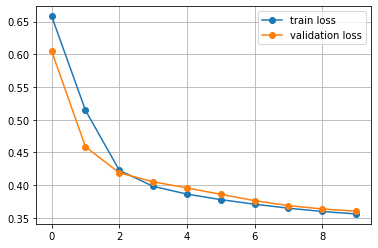

In [19]:
plt.plot(global_train_loss, marker='o', label="train loss")
plt.plot(global_val_loss, marker='o', label="validation loss")
plt.grid()
plt.legend()

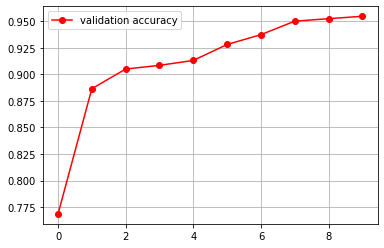

In [20]:
plt.plot(global_accuracy, marker='o', color='r', label='validation accuracy')
plt.grid()
plt.legend()

In [18]:
torch.save(cnn.state_dict(), '/content/drive/MyDrive/models/mask_detector')